# Visa Status

In [1]:
import cleanup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import modules
import numpy as np
import matplotlib.cm as cm
plt.style.use('../own_style.mplstyle')

In [2]:
# cleanup.generate_cleaned_df()


In [3]:

col_list = ["case_status", "employer_city", 'decision_date']
visas_df = pd.read_csv('../data/us_perm_visas_cleaned.csv', usecols=col_list)

In [4]:
visas_df.dtypes

decision_date    object
case_status      object
employer_city    object
dtype: object

In [5]:
visas_df ["decision_date"]=pd.to_datetime(visas_df["decision_date"])

In [6]:
visas_df.dtypes

decision_date    datetime64[ns]
case_status              object
employer_city            object
dtype: object

In [7]:
visas_df.head()

,decision_date,case_status,employer_city
0,2012-02-01,Certified,NEW YORK
1,2011-12-21,Denied,CARLSTADT
2,2011-12-01,Certified,GLEN ALLEN
3,2011-12-01,Certified,FLUSHING
4,2012-01-26,Certified,ALBANY


In [8]:

visas_df.tail()

,decision_date,case_status,employer_city
374357,2016-12-30,Withdrawn,ANAHEIM
374358,2016-12-30,Withdrawn,REDMOND
374359,2016-12-30,Withdrawn,YPSILANTI
374360,2016-12-30,Withdrawn,PHOENIX
374361,2016-12-30,Withdrawn,SANTA CLARA


Überprüfung der Spalte case_status, da sie Informationen über den jeweiligen Visumsangetrag gentroffene Entscheidung enthaelt


In [9]:
for value in visas_df.case_status.unique():
    print(len(visas_df[visas_df['case_status'] == value])," occurrences of status '{}'".format(value))

181933  occurrences of status 'Certified'
25649  occurrences of status 'Denied'
148586  occurrences of status 'Certified-Expired'
18194  occurrences of status 'Withdrawn'


Datensatz enthält 18194 Fälle die zurückgezogen wurden 'withdrawn'. Da diese Fälle nicht relevant sind werden sie aus dem Datensatz gelöscht.

In [10]:
visas_df= visas_df[visas_df.case_status != 'Withdrawn']

Der Status 'certified' und der Status 'certified-expired' werden zu dem Wert 'certified' zusammengefasst, sodass es nur noch die Werte 'certified' und 'denied' hat.

Antragssteller des Visas haben nach Erhalt des Status 'certified' 6 Monate Zeit, das Formular I-140 einzureichen, bevor es abläuft und in den Status 'certified-expired' erhält.

Formular I-140 Quelle: Wikipedia Das Formular I-140, Immigrant Petition for Alien Worker (Einwanderungsantrag für ausländische Arbeitnehmer), ist ein Formular, das von einem potentiellen Arbeitgeber bei den United States Citizenship and Immigration Services (USCIS) eingereicht wird, um einen Ausländer zu ersuchen, dauerhaft in den USA zu arbeiten. Dies geschieht in dem Fall, dass der Arbeitnehmer in gewisser Weise als außergewöhnlich gilt oder wenn es in den USA keine qualifizierten Arbeitskräfte gibt.



In [11]:
visas_df.loc[visas_df.case_status == 'Certified-Expired', 'case_status'] = 'Certified'
visas_df.case_status.value_counts()

Certified    330519
Denied        25649
Name: case_status, dtype: int64

25649 Visa Bewerbungen wurden abgelehnt (7,2%). Jetzt werden Zeilen und Spalten entfernt. NaN Werte in Zeilen und Spalten ausschließen.

In [12]:
visas_df = visas_df.dropna(axis=1, how='all')
visas_df = visas_df.dropna(axis=0, how='all');

visas_df.shape


(356168, 3)

Keine NaN Werte mehr. Welche Spalten haben noch fehlende Werte. Anzeigen lassen der fehlenden Werte


In [13]:
for column in visas_df.columns:
    print("Attribute '{}' contains ".format(column),  visas_df[column].isnull().sum().sum(), "missing values")

Attribute 'decision_date' contains  0 missing values
Attribute 'case_status' contains  0 missing values
Attribute 'employer_city' contains  10 missing values


Einfügen der Spalte Antragsjahr. Dies soll dann in einem Balkendiagramm dargestellt werden um den Verlauf zu sehen. Fehlende Werte sollen spaeter entfernt werden.


[Text(0.5, 0, 'Visa application year'),
 Text(0, 0.5, 'Number of Visa applicatons')]

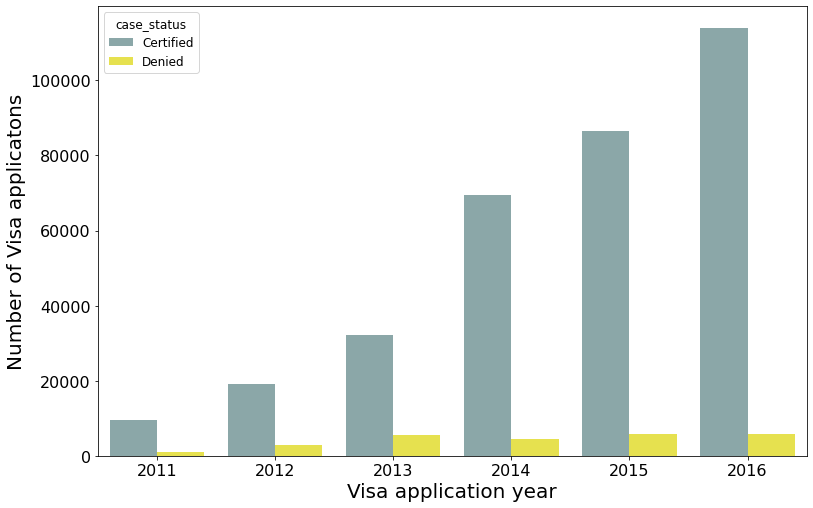

In [14]:
visas_df['year'] = visas_df['decision_date'].dt.year

fig, ax = plt.subplots()
fig.set_size_inches(12.7, 8.27)
sns.set_context(rc={"font.size":12})
sns.countplot(x="year", hue="case_status", data=visas_df)
ax.set(xlabel='Visa application year', ylabel='Number of Visa applicatons')


Anzahl der Visa Applications nimmt jedes Jahr zu. Die Anzahl der abgelehnten Anträge scheint seit 2013 zu stagnieren, bzw. ging 2014 leicht zurück

In welchen Städten werden die meisten Visa Applications gestellt?

In [15]:
visas_df['employer_city'] = visas_df['employer_city'].str.upper()
visas_df['employer_city'].value_counts().head(20)

NEW YORK           17212
COLLEGE STATION    11985
SANTA CLARA        10519
SAN JOSE            9150
REDMOND             8485
MOUNTAIN VIEW       8121
HOUSTON             6720
SAN FRANCISCO       6352
SUNNYVALE           6113
PLANO               5607
CHICAGO             5564
SEATTLE             5052
EDISON              4056
LOS ANGELES         4047
SAN DIEGO           3702
DALLAS              3693
PHILADELPHIA        3526
CUPERTINO           3310
PALO ALTO           3229
IRVING              3144
Name: employer_city, dtype: int64

Die beliebtesten Staedte waren in den letzten Jahren New York, College Station, Santa Clara, San Jose und Radmond. Plotten, grafische Darstellung der Visa Applications

[Text(0.5, 0, 'Employer city'), Text(0, 0.5, 'Number of Visa applications')]

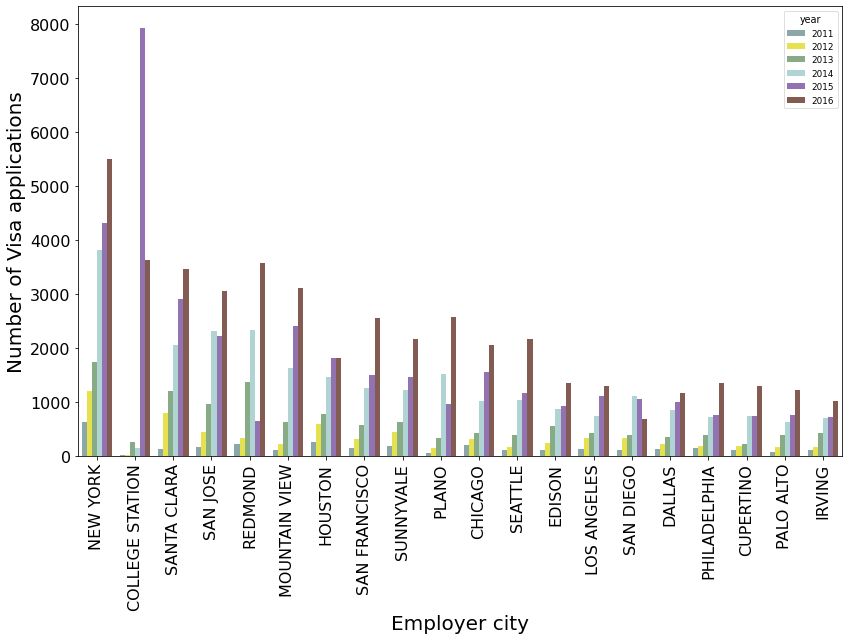

In [16]:
cmap = cm.get_cmap('RdYlGn')

fig, ax = plt.subplots()
fig.set_size_inches(13.7, 8.27)
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})
sns.countplot(x='employer_city', hue='year', data=visas_df, order=visas_df.employer_city.value_counts().iloc[:20].index)
plt.xticks(rotation=90)
ax.set(xlabel='Employer city', ylabel='Number of Visa applications')


College Station war im Jahr 2015 besonders beliebt (Begründung?). 2014 und 2016 war New York am beliebtesten. Allgemein ist ein ansteigender Trend der Visa Applications zu beobachten.

In [17]:

col_list = ["case_status", "case_received_date", "decision_date", "prevailing_wage_amount_9089", "prevailing_wage_unit_of_pay_9089", "class_of_admission"]
visas_df = pd.read_csv('../data/us_perm_visas_cleaned.csv', usecols=col_list)


C:\Users\andre\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [18]:

visas_df =  cleanup.convert_case_status_to_certified_or_denied(visas_df)

In [19]:
visas_df['decision_date'] = pd.to_datetime(visas_df["decision_date"])
visas_df
visas_df["decision_date_year"] = visas_df["decision_date"].dt.year

In [20]:
tmp = pd.DataFrame()
tmp = visas_df.groupby(["decision_date_year", "case_status"])["case_status"].count()

In [21]:
tmp = tmp.to_frame().unstack()

In [22]:
tmp


case_status       
case_status          Certified Denied
decision_date_year                   
2011                      9474   1128
2012                     19116   2838
2013                     32040   5433
2014                     69458   4423
2015                     86404   5934
2016                    114027   5893

In [23]:
tmp = tmp.reset_index()


In [24]:
tmp= tmp.set_index("decision_date_year")

In [25]:
tmp = tmp["case_status"]

In [26]:
tmp["relation"] = tmp["Denied"]/(tmp["Certified"]+ tmp["Denied"])

In [27]:
tmp

case_status,Certified,Denied,relation
decision_date_year,,,
2011,9474,1128,0.106395
2012,19116,2838,0.129270
2013,32040,5433,0.144984
2014,69458,4423,0.059867
2015,86404,5934,0.064264
2016,114027,5893,0.049141


<AxesSubplot:xlabel='decision_date_year'>

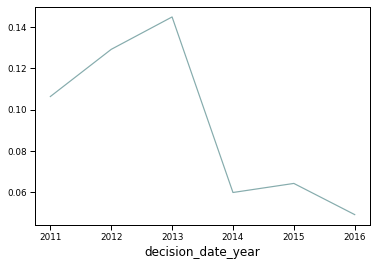

In [28]:
tmp["relation"].plot()


FAANG: http://conormclaughlin.net/2019/04/h1-b-visa-analysis/
https://www.statista.com/chart/22079/denial-rate-for-h1b-visa-petitions/